## Finding the value of HTC

First some imports, also some rc param to match the figure with the templates of the journal

In [2]:
import simulation
import importlib
importlib.reload(simulation)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from scipy import optimize

rc_param = {'font.size': 10, #controls default text size
            'axes.titlesize': 10, #fontsize of the title
            'axes.labelsize': 10, #fontsize of the x and y labels
            'xtick.labelsize': 10, #fontsize of the x tick labels
            'ytick.labelsize': 10, #fontsize of the y tick labels
            'legend.fontsize': 10, #fontsize of the # legend
            'font.family':'Times New Roman',
            'axes.grid':True,
            'lines.linewidth':0.75
            }


plt.rcParams.update(rc_param)

Read the clean data

In [3]:
path = r"data/clean"
files = os.listdir(path)
df_to_fit = pd.read_csv(os.path.join(path, files[0]))

Setup the sensor position

In [4]:
A1 = 0 # blech
A2 = 50 + int(1/0.2)
A3 = 50 + int(4/0.2)
A4 = 50 + int(11/0.2)
A5 = 50 + int(30/0.2)
A6 = 50 + int(55/0.2)

sensor_position = {
    "A1": A1,
    "A2": A2,
    "A3": A3,
    "A4": A4,
    "A5": A5,
    "A6": A6
}

Setting the simulation up, the residual function and finally the cost.
The cost is then minimized using the correct algorithm of scipy.

In [6]:
theta_fit = []
theta_data = []
opti_val = []
for a_file in files:
    print(f"Optimizing {a_file}")
    df_to_fit = pd.read_csv(os.path.join(path, a_file))

    def run_one_sim(lambda_w = 45, lambda_b = 120, h_c = 4500e3, cp_w=465, cp_b=600):
        theta_out = dict()

        my_sim = simulation.ThermoSimulation()
        my_sim.lambda_b = lambda_b
        my_sim.lambda_w = lambda_w
        my_sim.h_c = h_c
        my_sim.cp_w = cp_w
        my_sim.cp_b = cp_b
        my_sim.theta_room = df_to_fit["A6"].to_numpy()[0]
        my_sim.theta_blech = df_to_fit["A1"].to_numpy()[0]
        my_sim.i_snap = np.array(df_to_fit["time"].to_numpy()/my_sim.dt, int)

        my_sim.prepare()
        my_sim.compute()

        theta_out["time"] = my_sim.time_list

        for a_key, a_pos in sensor_position.items():
            theta_out[a_key] = my_sim.temp_list[:, a_pos]

        return theta_out

    def residuals_scalar(hc):
        sqr_error = []
        theta_out = run_one_sim(h_c=hc)
        for i in range(1,7):
            err = (df_to_fit[f"A{i}"] - theta_out[f"A{i}"])/df_to_fit[f"A{i}"]*100
            sqr_error.append(err)
        return np.hstack(sqr_error)

    def cost_residual(hc):
        err = residuals_scalar(hc)
        cost = np.sum(np.abs(err))/len(err)
        print(hc, cost, np.sum(err**2), len(err))
        return np.sum(err**2)

    res_s = optimize.minimize_scalar(cost_residual, bracket=(60000e3, 500000e3), bounds=(0, 5000000e3), method="bounded", options={"disp":True})
    if res_s.success:
        opti_val.append(res_s.x)
    else: opti_val.append(np.nan)
    theta_fit.append(run_one_sim(h_c=res_s.x))
    theta_data.append(df_to_fit)


Optimizing Heat-transfer_0004.csv
1909830056.2505255 4.294811989257913 138772.06283889062 906
3090169943.7494736 4.299538982247432 139333.3263900447 906
1180339887.4989486 4.287130798395209 137866.06695684785 906
729490168.7515774 4.274561560495601 136405.77545532997 906
450849718.7473713 4.253973633293305 134063.73407307387 906
278640450.0042062 4.22022555176677 130343.43695700477 906
172209268.7431652 4.165078680047664 124537.37628106355 906
106431181.26104099 4.075645157718924 115738.04610636397 906
65778087.48212423 3.932663064545133 102975.12870011835 906
40653093.77891677 3.7081369593027196 85571.39393118868 906
25124993.70320747 3.3626344897170504 63758.800189188834 906
15528100.075709306 2.8421325282961565 39428.10220255779 906
9596893.627498168 2.0742437292381473 16726.928725900845 906
5931206.448211141 0.9708849576490296 2209.1537904813404 906
3665687.1792870285 1.0503561187238444 4338.517465209072 906
5367257.625897982 0.7052376515216089 979.59011990216 906
5054731.642968233

Making a plot of the results

In [55]:
%matplotlib qt
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12/2.54, 11/2.54), dpi=150)

pressure = [0, 10, 30, 50]
for j, (a_df, a_fit) in enumerate(zip(theta_data, theta_fit)):
    for i in range(3):
        for k in range(2):
            l = i*2+k+1
            if l != 6:
                if l==1:
                    axs[i, k].plot(a_df["time"], a_df[f"A{l}"], f"-C{j}",  label=f"{pressure[j]} MPa (Exp.)")
                    axs[i, k].plot(a_df["time"], a_fit[f"A{l}"], f"--C{j}", label=f"{pressure[j]} MPa (Sim.)")
                else:
                    axs[i, k].plot(a_df["time"], a_df[f"A{l}"], f"-C{j}")
                    axs[i, k].plot(a_df["time"], a_fit[f"A{l}"], f"--C{j}")
                axs[i, k].set_title(f"Thermocouple {l}", pad=2.0)
                axs[i, k].set_ylabel("Temperature in K")
                axs[i, k].set_xlabel(f"Time in s", labelpad=-0.5)
                axs[i, k].locator_params(axis="x", nbins=5)
                axs[i, k].locator_params(axis="y", nbins=4)


#axs[i].set_ylim(100, 300)

axs[-1, -1].bar(pressure, np.array(opti_val) * 1e-6, color = [f"C{i}" for i in range(4)], width=3)
axs[-1, -1].set_axisbelow(True)
axs[-1, -1].grid(True, zorder=-4)
axs[-1, -1].set_xlabel("Pressure in MPa", labelpad=-0.5)
axs[-1, -1].set_ylabel("$h_\mathrm{c}$ in kW/m²/K")
axs[-1, -1].set_yticks((0, 5, 10, 15, 20, 25))
axs[-1, -1].set_xticks((0, 10, 20, 30, 40, 50))

fig.legend(loc="lower center", ncols=4, framealpha=1.0, edgecolor="k", bbox_to_anchor=(0.5, -0.0), labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handlelength=1.0, handletextpad=0.2)

plt.subplots_adjust(top=0.955,
                    bottom=0.208,
                    left=0.135,
                    right=0.962,
                    hspace=0.775,
                    wspace=0.347)

fig.savefig("results.svg")

Plotting a histogram of the errors

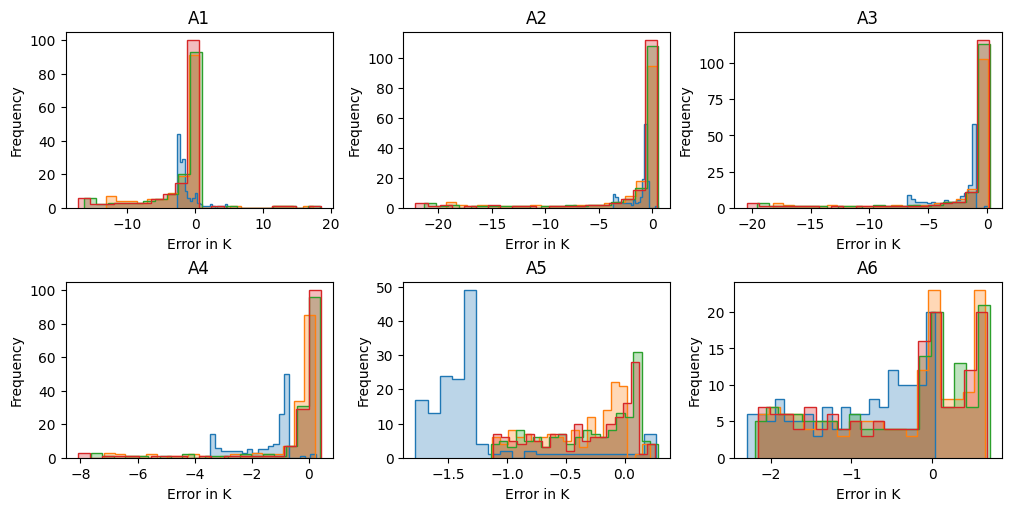

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), layout="constrained")
for j, (a_df, a_fit) in enumerate(zip(theta_data, theta_fit)):
    for i in range(2):
        for k in range(3):
            err = a_fit[f"A{3*i+k+1}"] - a_df[f"A{3*i+k+1}"]
            axs[i, k].hist(err, histtype="step", color=f"C{j}", label=f"{pressure[i]}", bins=20)
            axs[i, k].hist(err, histtype="bar", color=f"C{j}", alpha=0.3, label=f"{pressure[i]}", bins=20)
            axs[i, k].set_title(f"A{3*i+k+1}")
            axs[i, k].set_ylabel("Frequency")
            axs[i, k].set_xlabel("Error in K")


HTC as a function of contact pressure

Text(0, 0.5, '$h_c$ in W/m²/K')

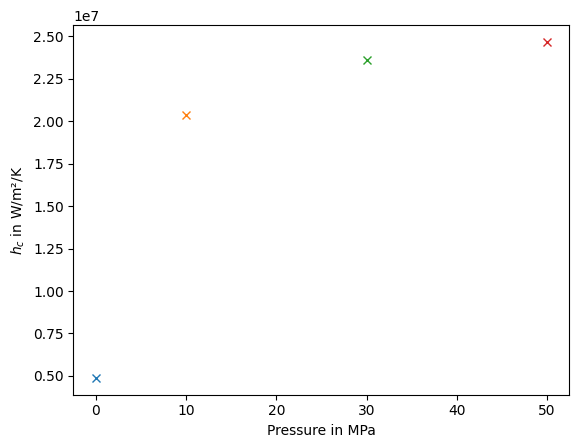

In [89]:
fig, ax = plt.subplots()
for a_p, a_h in zip(pressure, opti_val):
    ax.plot(a_p, a_h, "x")

ax.set_xlabel("Pressure in MPa")
ax.set_ylabel("$h_c$ in W/m²/K")
